**Introduction**

The Boston Crime dataset contains the categories, locations and dates all crime that happened in Boston between 2016 and 2018. In the following EDA, I will take a closer look at the data and provide some interesting insights.

Changelog
* v1.0 Draft notebook.
* v1.1 Additional plots added.
* v1.2 Added comments to the notebook.
* v1.3 Additional commenting, questions, plots added.

**Data preparation and cleaning**

In [1]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
import datetime
import folium #Geoploting library
from folium.plugins import HeatMap 
%matplotlib inline

In [2]:
#Importing the dataset
df = pd.read_csv(r"./data/crimedata.csv",encoding = 'unicode_escape')

/Users/Ann/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#List of columns to drop
columns_to_drop = ["INCIDENT_NUMBER", #Unneccecary
                  "OFFENSE_CODE", #Better to use group
                  "OFFENSE_DESCRIPTION", #Better to use group
                  "REPORTING_AREA", #Not needed
                  "UCR_PART", #Not needed
                  "Location"] #Loc and Lat columns are already there

#Apply the column drop
df.drop(columns_to_drop, axis=1, inplace=True)

#Replace the -1 in the Lat & Long column with NaN
df["Lat"].replace(-1,np.nan,inplace=True)
df["Lat"].replace(-1,np.nan,inplace=True)

#Adding a "No" to the shooting column
df["SHOOTING"].fillna("N", inplace=True)

#Converting to datetime
df["OCCURRED_ON_DATE"] = pd.to_datetime(df["OCCURRED_ON_DATE"])

#Renaming some crimes
rename_crimes = {"INVESTIGATE PERSON": "Investigate Person",
                         "HUMAN TRAFFICKING" : "Human Trafficking",
                         "HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE": "Involuntary Servitude"}
df["OFFENSE_CODE_GROUP"].replace(rename_crimes,inplace=True)

In [30]:
df.iloc[:,6]



0            Sunday
1          Saturday
2          Saturday
3          Saturday
4         Wednesday
            ...    
426835     Thursday
426836     Thursday
426837     Thursday
426838     Thursday
426839      Tuesday
Name: DAY_OF_WEEK, Length: 426840, dtype: object

**General look at the data**

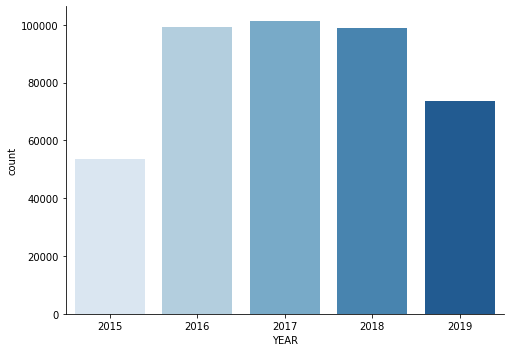

In [4]:
sns.catplot(x="YEAR", kind="count", palette="Blues",height=5, aspect=7/5, data=df)

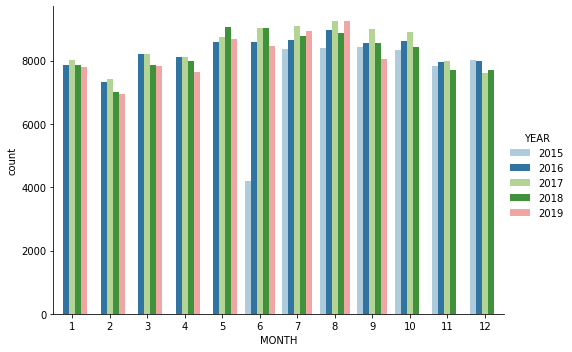

In [5]:
sns.catplot(x="MONTH", hue="YEAR", kind="count", palette="Paired",height=5, aspect=7/5, data=df)

Notice how the data for both 2016 and 2018 abruptly stops. The half-completed months will be a problem when looking at monthly data as they will have less crime in total. This is something we have to keep in mind going forward.

**Monthly crime**

/Users/Ann/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(5000, 10000)

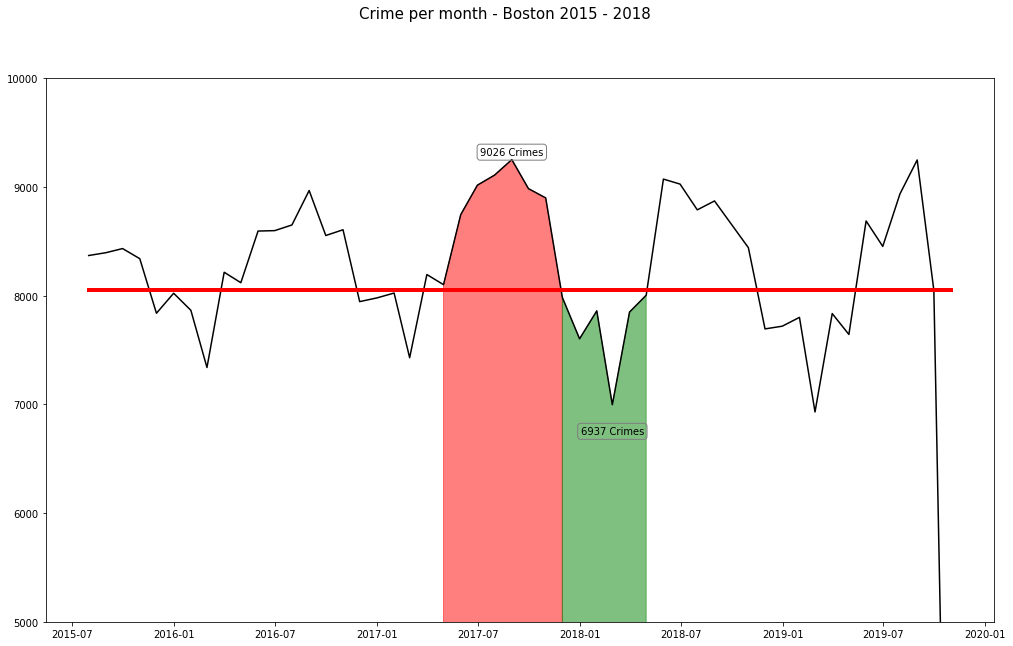

In [6]:
crimes_per_month = df.set_index("OCCURRED_ON_DATE") #Set datetime as index
crimes_m = pd.DataFrame(crimes_per_month.resample("M").agg(dict(OFFENSE_CODE_GROUP="size"))) #Resample on a monthly basis
crimes_m["mean"] = crimes_m["OFFENSE_CODE_GROUP"].mean() #Calculate the mean for the data

# Remove two incomplete dates
incomplete_dates = ["2018-09-30", "2015-06-30"]
crimes_m = crimes_m.drop(pd.to_datetime(incomplete_dates))

fig, ax = plt.subplots(figsize=(17, 10))
plt.style.use('seaborn-dark-palette')
ax.plot(crimes_m["OFFENSE_CODE_GROUP"], label="Crimes per month", color="black")
ax.plot(crimes_m["mean"], label="Mean montly crime", color="r", linewidth=4)

#Highs Lows
high = crimes_m[crimes_m.index >= "2017-04-30"]
high = high[high.index <= "2017-11-30"]
low = crimes_m[crimes_m.index >= "2017-11-30"]
low = low[low.index <= "2018-04-30"]

ax.fill_between( high.index, high["OFFENSE_CODE_GROUP"], color="red", alpha=0.5)
ax.fill_between( low.index, low["OFFENSE_CODE_GROUP"], color="green", alpha=0.5)

ax.annotate("6937 Crimes", xy=('2018-02-28', 7000),  xycoords='data',size=10,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(0, -30), textcoords='offset points', ha='center')
ax.annotate("9026 Crimes", xy=("2017-08-31", 9200),  xycoords='data',size=10,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(0, 10), textcoords='offset points', ha='center')

fig.suptitle("Crime per month - Boston 2015 - 2018", fontsize=15)
plt.ylim(5000,10000)  

Both the peak and valley for crime was marked on the plot above. Additionally, the mean value was placed as a point of reference. We will take the year with the peak and plot it next to the average temperature of the city. To make sure that we are doing this correctly, I have enabled the shared x-axis function.

In [7]:
#The most crimes happened in a 2017 month so we are going to find temperature data from it
date = ["31.1.2017","28.2.2017","31.3.2017","30.4.2017","31.5.2017","30.6.2017","31.7.2017","31.8.2017","30.9.2017","31.10.2017","30.11.2017"
        ,"31.12.2017"]
avrg_temp = [35.15,36.65,34.05,51.65,56.35,69.5,72.5,72,67.1,61.35,43.75,30.75]
temperature_data = pd.DataFrame(date,columns=["Date"])
temperature_data["Date"] = pd.to_datetime(temperature_data["Date"])
temperature_data["F Temperate"] = avrg_temp

Text(0.5, 0.98, 'Crime vs Temperature 2017')

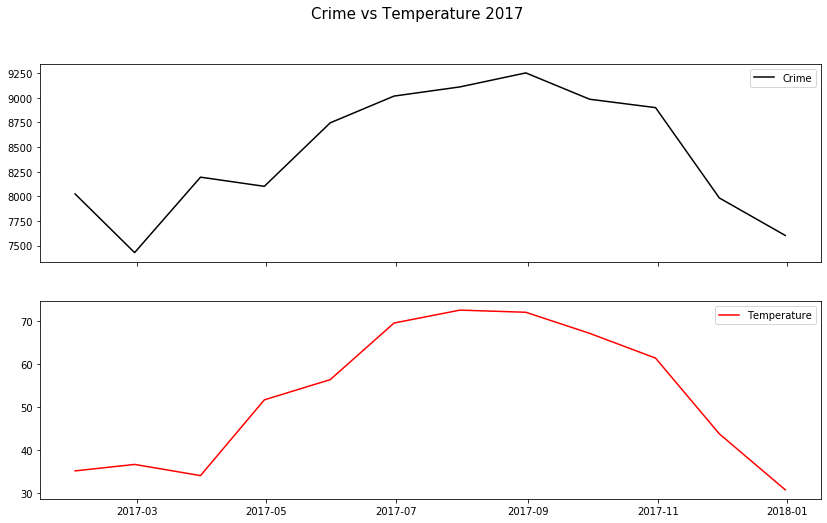

In [8]:
df_month_2017 = df[df["YEAR"]==2017]
df_month_2017 = df_month_2017.set_index(df_month_2017["OCCURRED_ON_DATE"]).resample("M").agg({"OFFENSE_CODE_GROUP" : "size"})

# Plot this I guess
fig,(ax1, ax2) = plt.subplots(2, 1,figsize=(14,8), sharex=True)
plt.style.use('seaborn-dark-palette')
ax1.plot(df_month_2017.index,df_month_2017["OFFENSE_CODE_GROUP"],
         label="Crime",color="black")
ax1.legend()

ax2.plot(temperature_data["Date"],temperature_data["F Temperate"],
         label="Temperature",color="r")
ax2.legend()

fig.suptitle("Crime vs Temperature 2017", fontsize=15)

There is an interesting correlation between high temperatures and the rise of crime in the city.

**Daily and hourly crime**

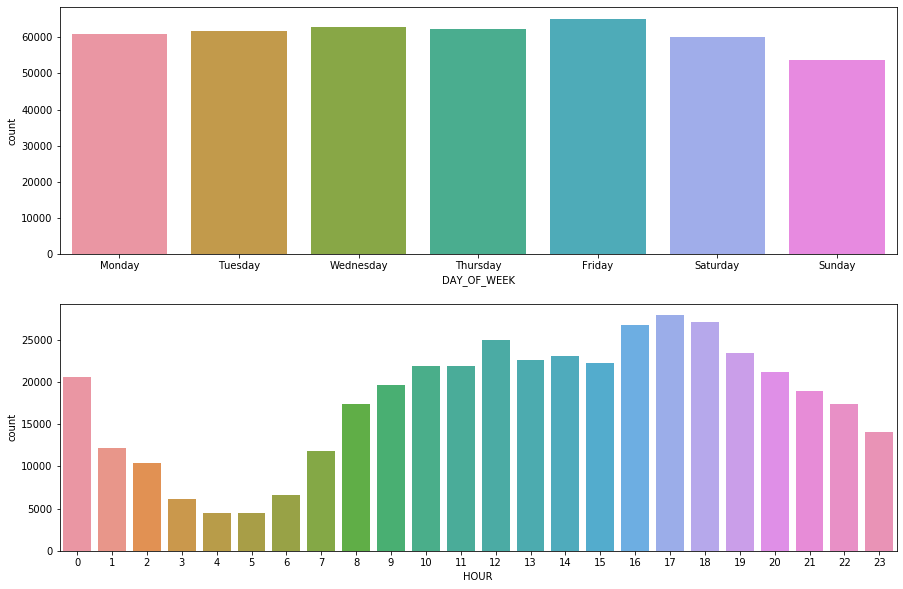

In [9]:
day_order = ["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday" ]
fig , (ax1,ax2) = plt.subplots(2,1, figsize=[15,10])

p1 = sns.countplot("DAY_OF_WEEK", data=df,order=day_order, ax = ax1)
p2 = sns.countplot("HOUR", data=df, ax = ax2)

We can see that crime takes a bit of a break during Sunday. If we look at the hours we can see that the least crime happens in 05:00 in the morning while the most crime happens around 16:00 to 18:00. This can potentially be related to the end of the workday and people travelling back home. It might be worth investigating in the future.

We are going to look into all the data we have available to plot a line graph with an upper and lower control limit. This will help us identify outliers that we can further investigate.

In [10]:
crime_per_day = df.set_index("OCCURRED_ON_DATE")

In [11]:
crimes = pd.DataFrame(crime_per_day.resample("D").size())
crimes["mean"] = crime_per_day.resample("D").size().mean()
crimes["std"] = crime_per_day.resample("D").size().std()
UCL = crimes["mean"] + 3 * crimes["std"]
LCL = crimes["mean"] - 3 * crimes["std"]

Text(0.5, 0.98, 'Crime per day - Boston 2015 - 2018')

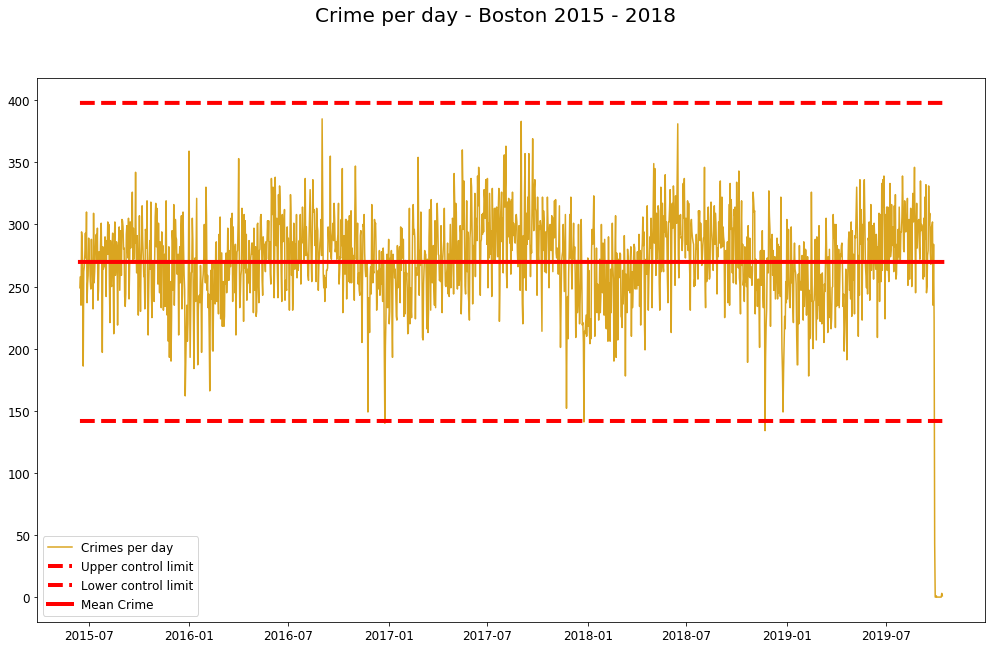

In [12]:
fig, ax = plt.subplots(figsize=(17, 10))
plt.style.use('seaborn-dark-palette')
ax.plot(crimes[[0]], label="Crimes per day", color="goldenrod")
ax.plot(UCL, color="red",linewidth=4,linestyle="dashed",label="Upper control limit")
ax.plot(LCL, color="red",linewidth=4,linestyle="dashed",label="Lower control limit")
ax.plot(crimes["mean"], color="red",linewidth=4, label="Mean Crime")
ax.tick_params(labelsize=12)
plt.legend()
plt.legend(loc=0, fontsize="large")
fig.suptitle("Crime per day - Boston 2015 - 2018", fontsize=20)

We can see a few outliers that happen around the end of the year. This can potentially be related to the holiday season and we will investigate this further. To do this, we will take only the data from 2017 and plot it in a daily life graph pointing at the most popular holidays of the year.

In [13]:
crime_per_day_2017 = crime_per_day[crime_per_day["YEAR"] == 2017]
crimes_2017 = pd.DataFrame(crime_per_day_2017.resample("D").size())

Text(0, 0.5, 'Crime per day')

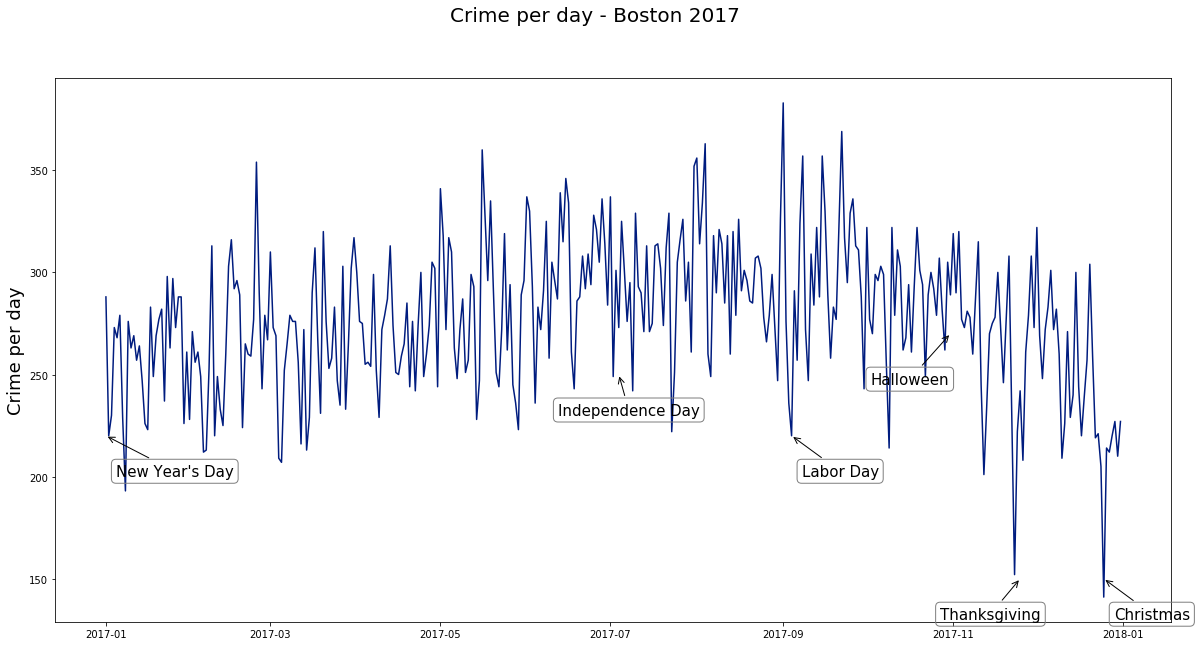

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(crimes_2017[[0]], label="Crimes per day")


ax.annotate("Independence Day", xy=('2017-7-4', 250),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("New Year's Day", xy=('2017-1-1', 220),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Labor Day", xy=('2017-9-4', 220),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Halloween", xy=('2017-10-31', 270),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(-80, -50), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Thanksgiving", xy=('2017-11-25', 150),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(-80, -40), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Christmas", xy=('2017-12-25', 150),  xycoords='data',size=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='left',
            arrowprops=dict(arrowstyle="->"))
fig.suptitle("Crime per day - Boston 2017", fontsize=20)
plt.ylabel('Crime per day', fontsize=18)

Some holidays have a major impact on crime, but they might not be the only factor involved. We have to keep in mind that the holiday season is during winter during lower temperatures.

**Most and least frequent crimes**

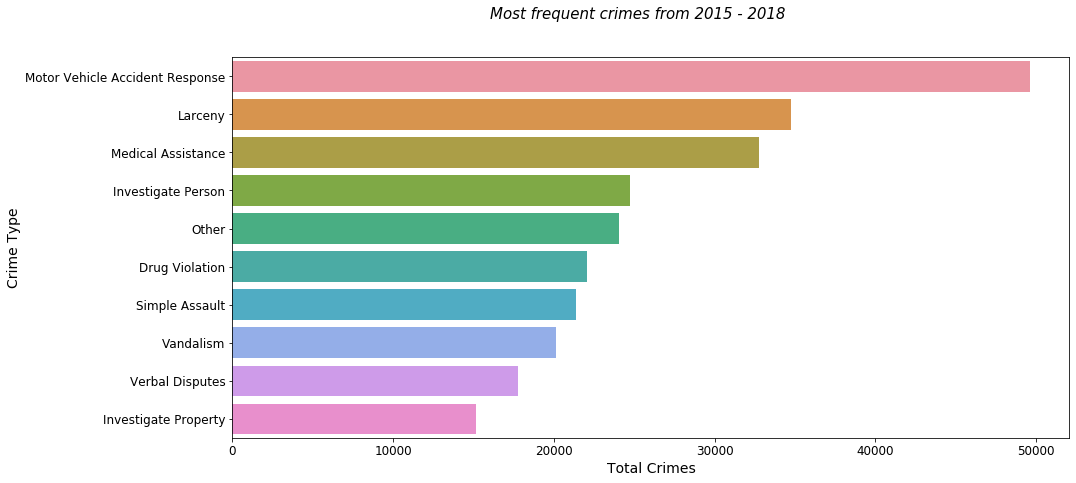

In [15]:
ax,fig = plt.subplots(figsize=(15,7))
sns.countplot(y = df["OFFENSE_CODE_GROUP"],order=df["OFFENSE_CODE_GROUP"].value_counts()[:10].index)
plt.suptitle("Most frequent crimes from 2015 - 2018", fontsize=15, fontweight=0, color='black', style='italic')
plt.ylabel("Crime Type", fontsize=14)
plt.xlabel("Total Crimes", fontsize=14)
fig.tick_params(labelsize=12)

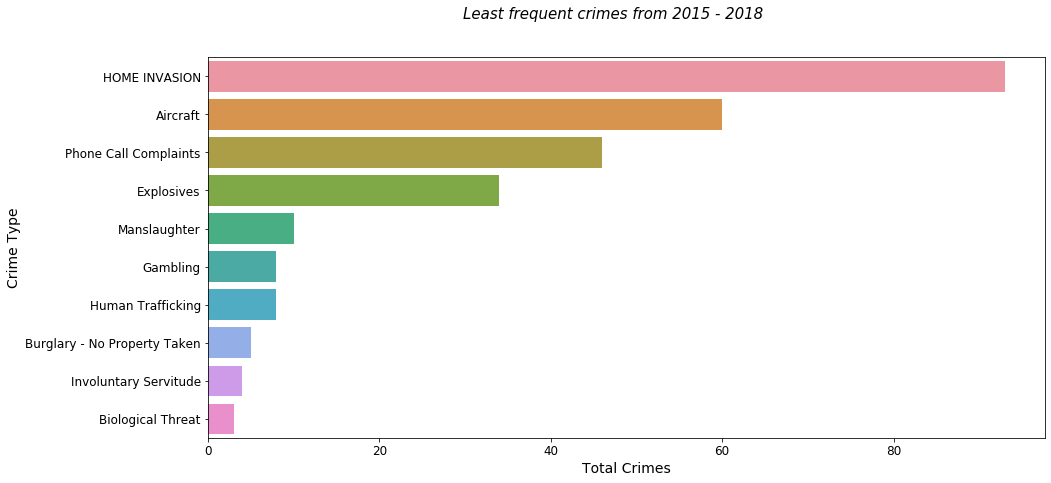

In [16]:
ax,fig = plt.subplots(figsize=(15,7))
sns.countplot(y = df["OFFENSE_CODE_GROUP"],order=df["OFFENSE_CODE_GROUP"].value_counts()[-10:].index)
plt.suptitle("Least frequent crimes from 2015 - 2018", fontsize=15, fontweight=0, color='black', style='italic')
plt.ylabel("Crime Type", fontsize=14)
plt.xlabel("Total Crimes", fontsize=14)
fig.tick_params(labelsize=12)

**Most frequent crimes on Christmas**

In [17]:
christmas_crime = df[df["OCCURRED_ON_DATE"] >= "2017-12-25"]
christmas_crime = christmas_crime[christmas_crime["OCCURRED_ON_DATE"] < "2017-12-26"]

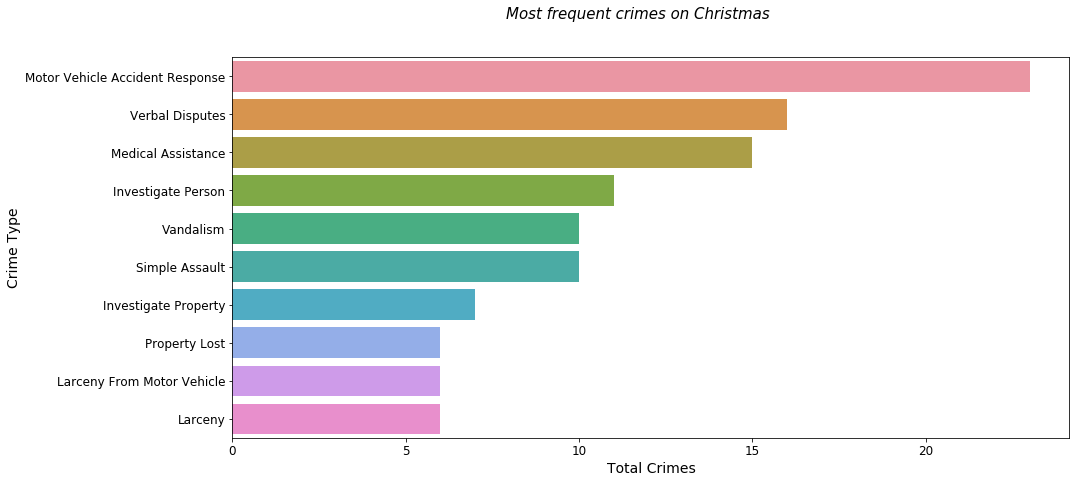

In [18]:
ax,fig = plt.subplots(figsize=(15,7))
sns.countplot(y = christmas_crime["OFFENSE_CODE_GROUP"],order=christmas_crime["OFFENSE_CODE_GROUP"].value_counts()[:10].index)
plt.suptitle("Most frequent crimes on Christmas", fontsize=15, fontweight=0, color='black', style='italic')
plt.ylabel("Crime Type", fontsize=14)
plt.xlabel("Total Crimes", fontsize=14)
fig.tick_params(labelsize=12)

Verbal and simple assaults moved a few places as the most frequent crimes Christmas.

In [31]:
christmas_crime_map = folium.Map(location=[42.3601, -71.0589],
              zoom_start = 12)
christmas_crime_loc = christmas_crime[["Lat", "Long"]]
christmas_crime_loc.dropna(inplace=True)
HeatMap(christmas_crime_loc, radius = 20).add_to(christmas_crime_map)
christmas_crime_map

/Users/Ann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


**Gun crime**

In [20]:
gun_crime_df = crime_per_day[crime_per_day["SHOOTING"] == "Y"]
gun_crime_per_day = pd.DataFrame(gun_crime_df.resample("M").size())
gun_crime_per_day["mean"] = gun_crime_df.resample("M").size().mean()

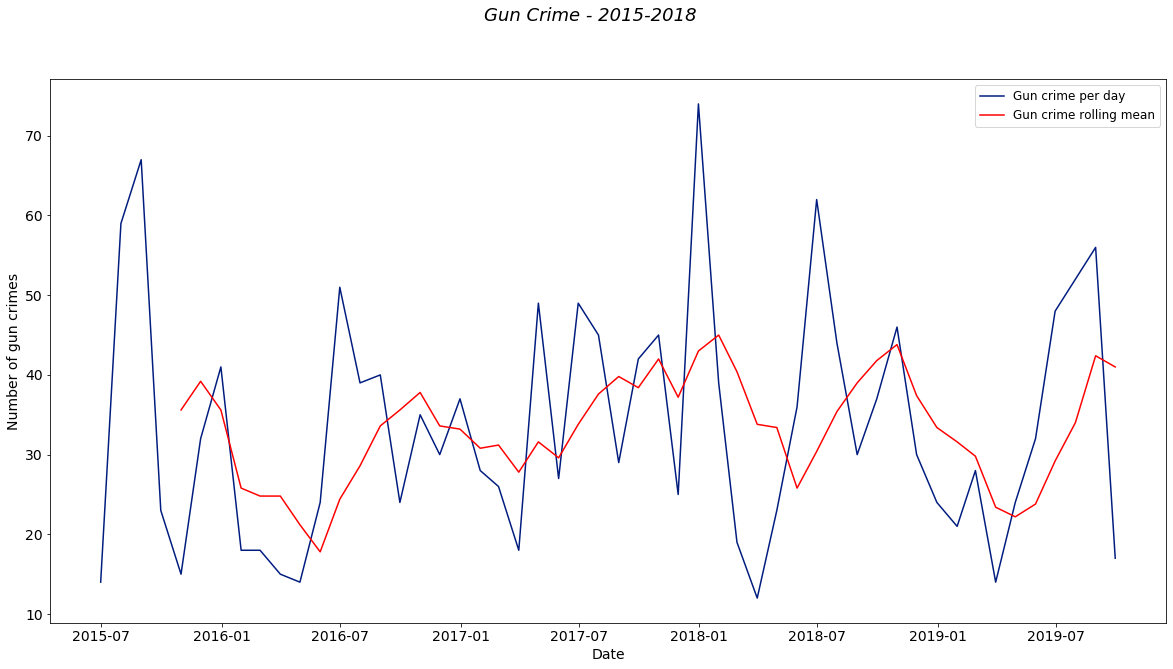

In [21]:
#Ploting with an window = 5 or SMA = 5 rolling mean.
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(gun_crime_per_day[[0]], label = "Gun crime per day")
ax.plot(gun_crime_per_day[[0]].rolling(window=5).mean(), color = "red", label="Gun crime rolling mean")
plt.suptitle("Gun Crime - 2015-2018", fontsize=18, fontweight=0, color='black', style='italic')
plt.legend(loc=0, fontsize="large")
plt.ylabel("Number of gun crimes", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.tick_params(labelsize=14)

On the Gun Crime plot, we can observe that there is a usually between 25 - 35 shootings per day. To further analyse this we will look at both the location of the gun crime and the most frequent crime types with shootings.

In [22]:
boston_shooting_map = folium.Map(location=[42.3601, -71.0589],
              zoom_start = 12)
shooting_location = gun_crime_df[["Lat", "Long"]]
shooting_location.dropna(inplace=True)

/Users/Ann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
HeatMap(shooting_location, radius = 20).add_to(boston_shooting_map)
display(boston_shooting_map)

In [24]:
crimes_with_guns = gun_crime_df["OFFENSE_CODE_GROUP"].value_counts()[:10]
top_gun_crimes = gun_crime_df[gun_crime_df["OFFENSE_CODE_GROUP"].isin(crimes_with_guns.index)]

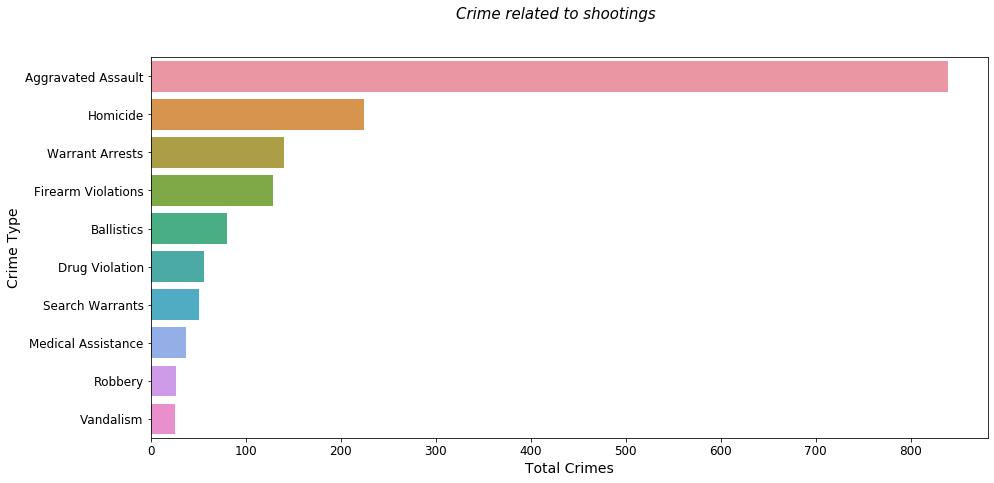

In [25]:
ax,fig = plt.subplots(figsize=(15,7))
sns.countplot(y = top_gun_crimes["OFFENSE_CODE_GROUP"], order=crimes_with_guns.index, data=top_gun_crimes)
plt.suptitle("Crime related to shootings", fontsize=15, fontweight=0, color='black', style='italic')
plt.ylabel("Crime Type", fontsize=14)
plt.xlabel("Total Crimes", fontsize=14)
fig.tick_params(labelsize=12)

In [26]:
ten_freq_crimes = df["OFFENSE_CODE_GROUP"].value_counts()[:12]
df_top_crimes = df[df["OFFENSE_CODE_GROUP"].isin(ten_freq_crimes.index)]

In [27]:
df_tp = df_top_crimes.pivot_table(index=df_top_crimes["OCCURRED_ON_DATE"],
                                                      columns=["OFFENSE_CODE_GROUP"],aggfunc="size", fill_value=0).resample("M").sum()

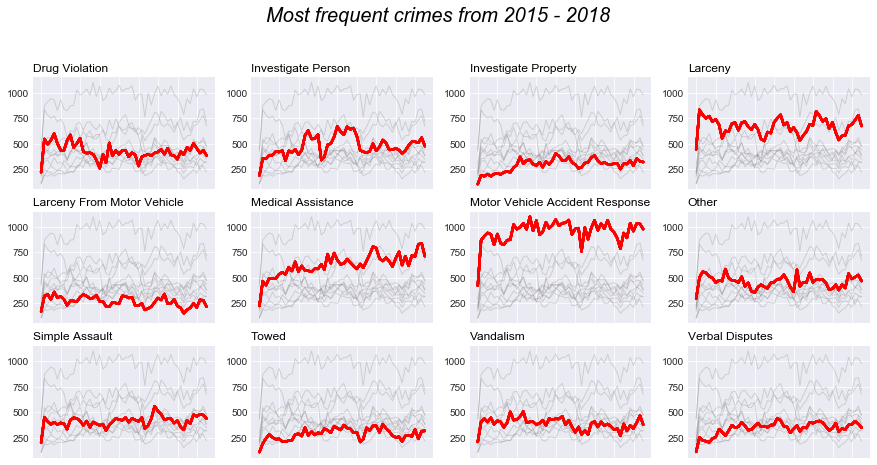

In [28]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
num=0
ax,fix = plt.subplots(figsize=(15,7))
for column in df_tp:
    num+=1
    plt.subplot(3,4, num)
    for v in df_tp:
        plt.plot(df_tp.index,v,data=df_tp,marker='', color='grey', linewidth=0.9, alpha=0.3)
        plt.tick_params(labelbottom=False)
        plt.plot(df_tp.index,column, data=df_tp,color="red", linewidth=2.4, alpha=0.9, label=column)
        plt.title(column, loc='left', fontsize=12, fontweight=0, color="black")
        plt.suptitle("Most frequent crimes from 2015 - 2018", fontsize=20, fontweight=0, color='black', style='italic', y=1.02)


Some crimes behave differently over time. While Investigate person has seen its ups and downs Medical Assistance is slowly increasing over time. 

**EDA Conclusions**


* We can fairly certainly say that holidays and temperature have a big impact on the number of crimes committed.
* Most of the crime happens on Friday, while the least happens on Sunday.
* The most frequent "crime" in Boston are Motor Vehicle Accidents while the second most are Larcenies.
* Guns are mostly used in Aggravated Assault followed by Homicides.
* Most of the crime happens around the Boston Downtown Crossing, Boston Commons and below.


Thank you for your time. Constructive feedback is always welcome.